# **Analisis dan Prediksi Kualitas Udara Menggunakan PySpark dan Random Forest Berbasis Big Data**

**NAMA :** Erhansa Pratama Aryana

**NIM :** 23.11.5761

**KELAS :** IF 07

Link Dataset : https://www.kaggle.com/datasets/mexwell/us-air-pollution

# **1. STUDI KASUS & DATASET**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mexwell/us-air-pollution")

print("Path to dataset files:", path)

100%|██████████| 25.6M/25.6M [00:00<00:00, 97.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mexwell/us-air-pollution/versions/1


# **2. LOAD DATASET (SIMULASI HDFS)**

In [2]:
# Buat folder HDFS simulasi
!mkdir -p /content/hdfs/us_air_pollution/




In [9]:
# Pindahkan dataset ke folder HDFS simulasi
!mv {path}/uspollution_pollution_us_2000_2016.csv /content/hdfs/us_air_pollution/

In [10]:
!pip install findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("US Air Pollution Data") \
    .getOrCreate()

# Load dataset dari "HDFS"
df = spark.read.csv(
    "/content/hdfs/us_air_pollution/uspollution_pollution_us_2000_2016.csv",
    header=True,
    inferSchema=True
)

df.show(5)
df.printSchema()

+---+----------+-----------+--------+--------------------+-------+--------+-------+----------+-----------------+---------+-----------------+----------------+-------+-----------------+--------+----------------+---------------+------+-----------------+--------+-----------------+----------------+-------+-----------------+--------+----------------+---------------+------+
|_c0|State Code|County Code|Site Num|             Address|  State|  County|   City|Date Local|        NO2 Units| NO2 Mean|NO2 1st Max Value|NO2 1st Max Hour|NO2 AQI|         O3 Units| O3 Mean|O3 1st Max Value|O3 1st Max Hour|O3 AQI|        SO2 Units|SO2 Mean|SO2 1st Max Value|SO2 1st Max Hour|SO2 AQI|         CO Units| CO Mean|CO 1st Max Value|CO 1st Max Hour|CO AQI|
+---+----------+-----------+--------+--------------------+-------+--------+-------+----------+-----------------+---------+-----------------+----------------+-------+-----------------+--------+----------------+---------------+------+-----------------+--------+-

# **3a. BATCH PROCESSING – MAPREDUCE (RDD)**

In [28]:
# Ambil kolom yang dibutuhkan lalu ubah ke RDD
rdd_no2 = df.select("State", "NO2 Mean").rdd

# MapReduce: hitung rata-rata NO2 per State
avg_no2_per_state = (
    rdd_no2
    .filter(lambda x: x[1] is not None)
    .map(lambda x: (x[0], (x[1], 1)))
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    .mapValues(lambda x: x[0] / x[1])
)

avg_no2_per_state.take(5)


[('Colorado', 19.634274501563095),
 ('District Of Columbia', 17.689366473614495),
 ('Illinois', 15.568193815986856),
 ('Kansas', 11.089180057560384),
 ('Oklahoma', 6.763139345438701)]

# **3b. EDA (EXPLORATORY DATA ANALYSIS)**

In [29]:
df = df.withColumnRenamed("NO2 Mean", "NO2") \
       .withColumnRenamed("O3 Mean", "O3") \
       .withColumnRenamed("SO2 Mean", "SO2") \
       .withColumnRenamed("CO Mean", "CO")


In [30]:
df.describe().show()


+-------+-----------------+------------------+-----------------+------------------+--------------------+-------+-------+-----------+-----------------+-----------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-----------------+
|summary|              _c0|        State Code|      County Code|          Site Num|             Address|  State| County|       City|        NO2 Units|              NO2| NO2 1st Max Value|  NO2 1st Max Hour|           NO2 AQI|         O3 Units|                  O3|    O3 1st Max Value|   O3 1st Max Hour|            O3 AQI|        SO2 Units|               SO2| SO2 1st Max Value|  SO2 1st Max Hour|           SO2 AQI|         CO Units|                 CO|  CO 1st Max Value|   CO 1st Max 

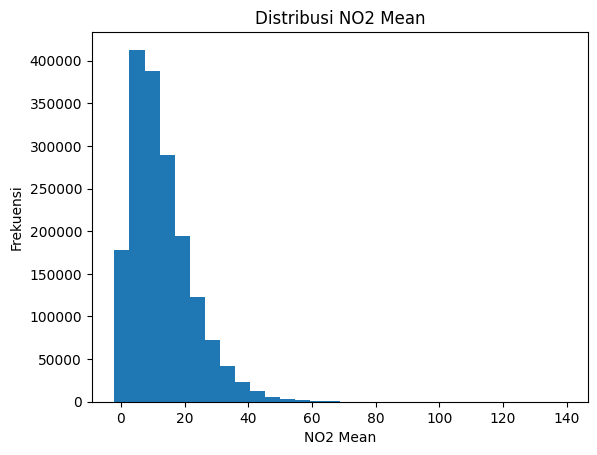

In [36]:
pdf = df.select("NO2").dropna().toPandas()

import matplotlib.pyplot as plt
plt.hist(pdf["NO2"], bins=30)
plt.title("Distribusi NO2 Mean")
plt.xlabel("NO2 Mean")
plt.ylabel("Frekuensi")
plt.show()

# TREN NO2 PER TAHUN

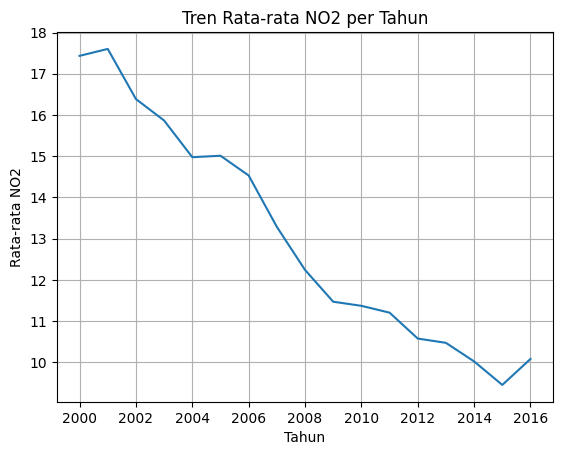

In [37]:

from pyspark.sql.functions import year
import matplotlib.pyplot as plt

df_year = df.withColumn("Year", year("Date Local"))

df_trend = (
    df_year
    .select("Year", "NO2")
    .dropna()
    .groupBy("Year")
    .avg("NO2")
    .orderBy("Year")
)


pdf_trend = df_trend.toPandas()

plt.plot(pdf_trend["Year"], pdf_trend["avg(NO2)"])
plt.title("Tren Rata-rata NO2 per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Rata-rata NO2")
plt.grid(True)
plt.show()


# ****3c. DATA PREPROCESSING (DATA QUALITY)****

In [39]:
from pyspark.sql.functions import col

df_clean = df.withColumnRenamed("NO2 Mean", "NO2") \
             .withColumnRenamed("O3 Mean", "O3") \
             .withColumnRenamed("SO2 Mean", "SO2") \
             .withColumnRenamed("CO Mean", "CO")

df_clean = df_clean.dropna(subset=["NO2", "O3", "SO2", "CO"])

df_clean = df_clean.select(
    "State",
    "Date Local",
    col("NO2").cast("double"),
    col("O3").cast("double"),
    col("SO2").cast("double"),
    col("CO").cast("double")
)

df_clean.printSchema()
df_clean.show(5)


root
 |-- State: string (nullable = true)
 |-- Date Local: date (nullable = true)
 |-- NO2: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- CO: double (nullable = true)

+-------+----------+---------+--------+--------+--------+
|  State|Date Local|      NO2|      O3|     SO2|      CO|
+-------+----------+---------+--------+--------+--------+
|Arizona|2000-01-01|19.041667|  0.0225|     3.0|1.145833|
|Arizona|2000-01-01|19.041667|  0.0225|     3.0|0.878947|
|Arizona|2000-01-01|19.041667|  0.0225|   2.975|1.145833|
|Arizona|2000-01-01|19.041667|  0.0225|   2.975|0.878947|
|Arizona|2000-01-02|22.958333|0.013375|1.958333|    0.85|
+-------+----------+---------+--------+--------+--------+
only showing top 5 rows


# **3d. MANIPULASI DATA – SPARK SQL, CTE, AGREGASI**

In [40]:
df_clean.createOrReplaceTempView("air_quality")


In [41]:
spark.sql("""
SELECT
    State,
    AVG(NO2) AS avg_no2
FROM air_quality
GROUP BY State
ORDER BY avg_no2 DESC
""").show()


+--------------------+------------------+
|               State|           avg_no2|
+--------------------+------------------+
|   Country Of Mexico|20.331830383968093|
|            Colorado|19.634274501563095|
|             Arizona|19.067975177548746|
|       Massachusetts|18.646618501205403|
|          New Jersey|18.595888292009683|
|            New York| 18.48822274927281|
|District Of Columbia|17.689366473614495|
|            Michigan|16.810260370814003|
|            Illinois|15.568193815986856|
|           Wisconsin| 14.96873165699212|
|            Missouri|14.961033508241348|
|           Louisiana|13.757875041970385|
|          California|13.651893627649123|
|                Utah|13.184445900784487|
|        Pennsylvania|12.416728753975615|
|          New Mexico|12.344544169424976|
|             Indiana|12.119476863851796|
|                Ohio|12.113816784686527|
|              Nevada|12.044494422355168|
|            Kentucky| 11.98944265327521|
+--------------------+------------

In [42]:
spark.sql("""
WITH avg_no2_state AS (
    SELECT
        State,
        AVG(NO2) AS avg_no2
    FROM air_quality
    GROUP BY State
)
SELECT *
FROM avg_no2_state
WHERE avg_no2 > 20
ORDER BY avg_no2 DESC
""").show()


+-----------------+------------------+
|            State|           avg_no2|
+-----------------+------------------+
|Country Of Mexico|20.331830383968093|
+-----------------+------------------+



In [43]:
spark.sql("""
SELECT
    State,
    AVG(NO2) AS avg_no2,
    AVG(O3) AS avg_o3,
    AVG(SO2) AS avg_so2,
    AVG(CO) AS avg_co
FROM air_quality
GROUP BY State
""").show()


+--------------------+------------------+--------------------+------------------+-------------------+
|               State|           avg_no2|              avg_o3|           avg_so2|             avg_co|
+--------------------+------------------+--------------------+------------------+-------------------+
|District Of Columbia|17.689366473614495| 0.02418425000000007| 4.209669610445201| 0.7901699817481318|
|               Texas|11.592394221852482|0.025767211560937524|0.9877124823712742|0.24795738329493297|
|        Pennsylvania|12.416728753975615| 0.02642546473116896| 4.041602040112847|0.24159189508819626|
|         Connecticut| 8.990964940700932| 0.02892005064644374|0.9121207620352152| 0.2508660111582455|
|              Nevada|12.044494422355168|  0.0320395945555784|0.3414223882243773|0.22120804330789853|
|            Illinois|15.568193815986856|0.022659037073988277|2.6830613666493774|0.39275933458376405|
|            Oklahoma| 6.763139345438701| 0.03137202986635681| 0.721274344683324|0

# **3e. PARTISI & OPERASI RDD**

In [44]:
rdd_air = df_clean.rdd


In [45]:
rdd_air.getNumPartitions()


3

In [46]:
rdd_repartitioned = rdd_air.repartition(4)
rdd_repartitioned.getNumPartitions()


4

In [47]:
rdd_map = rdd_repartitioned.map(lambda row: (row.State, row.NO2))
rdd_map.take(5)


[('Arizona', 29.666667),
 ('Arizona', 29.666667),
 ('Arizona', 25.083333),
 ('Arizona', 25.083333),
 ('Arizona', 25.083333)]

In [48]:
rdd_filter = rdd_map.filter(lambda x: x[1] > 20)
rdd_filter.take(5)


[('Arizona', 29.666667),
 ('Arizona', 29.666667),
 ('Arizona', 25.083333),
 ('Arizona', 25.083333),
 ('Arizona', 25.083333)]

In [49]:
rdd_sum_count = rdd_map.mapValues(lambda x: (x, 1)) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

rdd_avg = rdd_sum_count.mapValues(lambda x: x[0] / x[1])
rdd_avg.take(5)


[('Colorado', 19.634274501563063),
 ('Kansas', 11.089180057560341),
 ('North Carolina', 10.553093637558588),
 ('Virginia', 10.533040577398278),
 ('Nevada', 12.044494422355132)]

In [50]:
rdd_avg.collect()


[('Colorado', 19.634274501563063),
 ('Kansas', 11.089180057560341),
 ('North Carolina', 10.553093637558588),
 ('Virginia', 10.533040577398278),
 ('Nevada', 12.044494422355132),
 ('Oregon', 9.650598929964389),
 ('South Dakota', 5.073974402116399),
 ('Washington', 10.20509774428274),
 ('California', 13.651893627648692),
 ('District Of Columbia', 17.68936647361457),
 ('Florida', 7.3633862805772266),
 ('Michigan', 16.810260370814003),
 ('Texas', 11.592394221852576),
 ('Massachusetts', 18.64661850120533),
 ('South Carolina', 1.9394095085679288),
 ('Iowa', 6.787498031025207),
 ('Country Of Mexico', 20.33183038396802),
 ('Ohio', 12.113816784686481),
 ('Georgia', 11.226735516187533),
 ('Delaware', 11.584772992286494),
 ('Minnesota', 6.819423561832495),
 ('Utah', 13.184445900784503),
 ('Illinois', 15.568193815986925),
 ('Indiana', 12.119476863851787),
 ('Louisiana', 13.757875041970323),
 ('Missouri', 14.961033508241481),
 ('New Jersey', 18.595888292009576),
 ('New York', 18.488222749272907),
 (

# **4. MACHINE LEARNING – MLlib**

In [53]:
from pyspark.ml.feature import VectorAssembler

features = ["SO2", "CO", "O3"]

assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

data_ml = assembler.transform(df_clean) \
    .select("features", "NO2")

In [54]:
train, test = data_ml.randomSplit([0.8, 0.2], seed=42)


Model 1 – Linear Regression

In [56]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    labelCol="NO2",
    featuresCol="features"
)

lr_model = lr.fit(train)
lr_pred = lr_model.transform(test)

lr_pred.select("NO2", "prediction").show(5)

+---------+------------------+
|      NO2|        prediction|
+---------+------------------+
|23.608696|10.451162840643509|
|    7.375| 10.18240270494702|
|    7.375| 10.18240270494702|
| 8.333333| 9.840344350424214|
|10.958333|  9.67752457367136|
+---------+------------------+
only showing top 5 rows


Model 2 – Random Forest

In [58]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    labelCol="NO2",
    featuresCol="features",
    numTrees=50,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(train)
rf_pred = rf_model.transform(test)

rf_pred.select("NO2", "prediction").show(5)

+---------+------------------+
|      NO2|        prediction|
+---------+------------------+
|23.608696|11.297433424557237|
|    7.375|11.297433424557237|
|    7.375|11.297433424557237|
| 8.333333|11.297433424557237|
|10.958333|11.297433424557237|
+---------+------------------+
only showing top 5 rows


# **5. HYPERPARAMETER TUNING (BEST MODEL)**

In [68]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf = RandomForestRegressor(
    labelCol="NO2",
    featuresCol="features",
    seed=42
)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol="NO2",
    predictionCol="prediction",
    metricName="rmse"
)

cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cv_model = cv.fit(train)

best_model = cv_model.bestModel

best_predictions = best_model.transform(test)
rmse = evaluator.evaluate(best_predictions)

print("RMSE Model Terbaik:", rmse)
print("Jumlah Trees Terbaik:", best_model.getNumTrees)
print("Max Depth Terbaik:", best_model.getOrDefault("maxDepth"))

RMSE Model Terbaik: 6.3576130555988435
Jumlah Trees Terbaik: 50
Max Depth Terbaik: 10


# **6. EVALUASI MODEL**

In [71]:

from pyspark.ml.evaluation import RegressionEvaluator

# Prediksi data testing
predictions = best_model.transform(test)

# Evaluator RMSE
evaluator_rmse = RegressionEvaluator(
    labelCol="NO2",
    predictionCol="prediction",
    metricName="rmse"
)

# Evaluator MSE
evaluator_mse = RegressionEvaluator(
    labelCol="NO2",
    predictionCol="prediction",
    metricName="mse"
)

# Evaluator R2
evaluator_r2 = RegressionEvaluator(
    labelCol="NO2",
    predictionCol="prediction",
    metricName="r2"
)

# Hitung nilai evaluasi
rmse = evaluator_rmse.evaluate(predictions)
mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

# Tampilkan hasil
print("HASIL EVALUASI MODEL")
print(f"RMSE : {rmse}")
print(f"MSE  : {mse}")
print(f"R²   : {r2}")


HASIL EVALUASI MODEL
RMSE : 6.3576130555988435
MSE  : 40.41924376472087
R²   : 0.5507848088737317
